# Overview of Day 4
* Preliminaries
* What even is machine learning?
* Machine learning in Python: why scikit-learn?
* Feature extraction
* Feature selection
* Estimation
* Evaluation
* Automation


In [7]:
# We'll load scikit-learn modules as we go,
# so we can see what we're using.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

# Read in our preprocessed data set from Day 3.
# You may need to modify the path to the file
# depending on where you put it on your computer.
data = pd.read_csv('../data/preprocessed_data.csv')

# Since we'll be predicting outcomes, let's restrict
# to only common ones. It's hard to predict something
# we don't have very many training examples of.
data = data.groupby('outcome').filter(lambda x: len(x) >= 500)

# Let's also do some recoding to make life easier
data = data.dropna(subset=['age'])
categoricals = ['sex', 'sterilized']
data[categoricals] = data[categoricals].fillna('Unknown')

# Important, otherwise we have problems later
# when we try to concatenate based on index
data = data.reset_index()

# What even is machine learning?
<img src="https://s-media-cache-ak0.pinimg.com/736x/be/fc/cc/befcccae9891a505eabee71f7c808d4d.jpg" style="margin-bottom: 10px;">
* Better name might be "predictive modeling"
    * In contrast to traditional statistical approach, which might be called "explanatory modeling" [$^1$](https://projecteuclid.org/euclid.ss/1009213726),[$^2$](http://jakewestfall.org/publications/Yarkoni_Westfall_choosing_prediction.pdf)
    

* Traditional approach begins by positing a _data model_
    * e.g., linear regression model: $Y = \beta_0 + \beta_1X_1 + \ldots + \beta_pX_p + \epsilon$
    * ***"Assuming my model of how the data arose is correct, and given these parameter estimates, to what extent is variation in Y explained by variation in X?"***
    * Models should be interpretable in order to be useful
    

* In machine learning, overriding emphasis is just on whether we can accurately predict future Y values
    * ***"Regardless of what the true data model may be or what my parameter estimates look like, does my algorithm give outputs (Y) as close as possible to those of the true model when given the same inputs (X)?"***
    * If the model/algorithm is interpretable, that's a bonus, but not generally important
    * Premium placed instead on objective tests of accuracy in predicting new data

# Getting ahead of ourselves:
### Overfitting and in-sample vs. out-of-sample error
<img src="https://qph.ec.quoracdn.net/main-qimg-17ec84ff3f63f77f6b368f0eb6ef1890" style="margin-bottom: 10px;" width="1000px">

* How do we test for overfitting **before** the new data come in?
* By setting aside a fraction of our dataset -- no peeking! -- and pretending it's the future data
    * These set-aside data are called the *validation set*
* Example: We have 1000 samples in the full dataset. 
    * Fit the model to 900 samples (the training set)
    * Test how accurately the model predicts the remaining 100 samples (the validation set)
* This is the basic logic. In practice we often use a more sophisticated version of this called *cross-validation*. We'll return to this idea near the end of the class

# Machine learning in Python: why scikit-learn?
* There are hundreds of ML packages in Python
    * Theano, Tensorflow, orange, Pattern, PyMVPA, etc...
* But scikit-learn is dominant
    * Elegant, powerful interface
    * World-class documentation
    * Excellent performance
* The exception is deep learning--not supported in scikit-learn

# The typical predictive modeling pipeline
* Feature extraction/engineering
* Feature selection
* Model/parameter selection
* Estimation
* Evaluation
* Rinse and repeat ad nauseam

# Feature extraction
* Deriving *new* (informative, non-redundant) predictors/features from the features you already have
* Or adding entirely new features to the dataset (e.g., web scraping for dog breed stats)
* Simple example of feature extraction: Adding a squared term

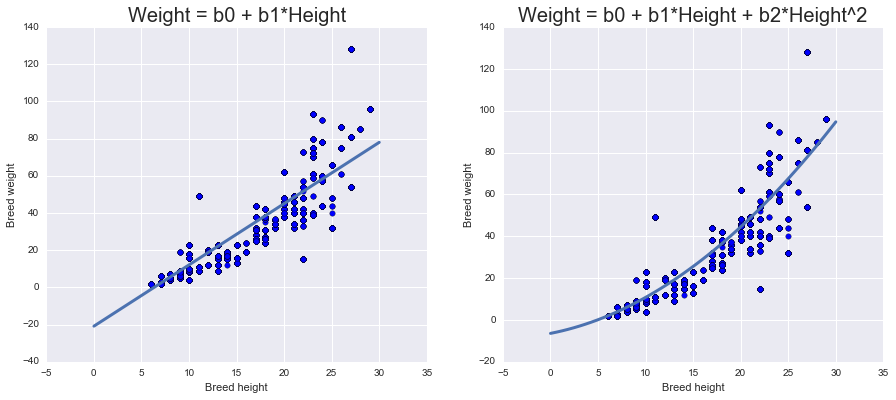

In [3]:
# set up the plotting space
fig, axes = plt.subplots(1, 2, figsize=(15,6))

# estimate a simple linear regression model, plot its predictions
linear_model = sm.OLS(data['min_weight'], sm.add_constant(data['height']), missing='drop')
a, b = linear_model.fit().params
axes[0].scatter(data['height'], data['min_weight'], s=30)
axes[0].set_ylabel("Breed weight")
axes[0].set_xlabel("Breed height")
axes[0].set_title("Weight = b0 + b1*Height", size=20)
axes[0].plot([0, 30], [a, a + b*30], lw=3)

# now add Height-squared to the model and plot the model predictions
quad_data = sm.add_constant(pd.DataFrame({'h':data['height'], 'h2':data['height']**2}))
quadratic_model = sm.OLS(data['min_weight'], quad_data, missing='drop')
a, b, c = quadratic_model.fit().params
axes[1].scatter(data['height'], data['min_weight'], s=30)
axes[1].set_ylabel("Breed weight")
axes[1].set_xlabel("Breed height")
axes[1].set_title("Weight = b0 + b1*Height + b2*Height^2", size=20)
X = np.linspace(0, 30)
axes[1].plot(X, [a + b*x + c*x**2 for x in X], lw=3);

## Getting _all_ the features
* Well, probably not all... but a _lot_
* How much information can we get out of the original dataset?
* From an interpretation-oriented standpoint, maybe not much more
* From a machine learning standpoint, we've just scratched the surface
* Some things we could add: names, colors, any number of interactions...
    * The cost of trying out silly things is much lower
    * Multicollinearity is not (much of) a concern

## Bag-of-words approach to handling fur color
* If you have a lot of data, it's not always worth thinking deeply about your features
* E.g., how should we model fur color?
    * "Black/Tricolor", "Calico Point", "Brown Brindle/Blue Cream"
* Simple approach: treat color descriptions like a [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)
* Extract all word tokens (possibly even N-grams)

In [4]:
# How many colors in total?
print(data['color'].nunique())

# First 20 unique colors in the dataset
data['color'].unique()[:20]

489


array(['Yellow/White', 'Tricolor', 'Brown/White', 'Black/White',
       'Black/Gray', 'White/Black', 'Brown Tabby/White', 'Black/Tan',
       'Tan/Black', 'Black', 'Gold/Gold', 'Sable/White', 'Blue Merle/Tan',
       'Blue Merle', 'Brown/Black', 'Black/Tricolor', 'Gray/White',
       'Black/Black', 'Tan', 'Black/Brown'], dtype=object)

### Applying the bag-of-words model

In [8]:
# The CountVectorizer is an estimator that takes a series
# of documents (or strings) as input, and returns a count
# of every word token found in every document. There's also
# a TfidfVectorizer in cases where we want normalized frequency.
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer with default parameters.
# Some common arguments we might want to experiment with
# include min_df and max_df (which exclude words that are
# too frequent or infrequent), stop_words (which allows
# us to pass in a list of words to ignore), and ngram_range,
# which enables us to extract multi-word features.
vec = CountVectorizer()

# Extract all possible word features from the color list.
# Note that this returns a sparse matrix rather than a
# numpy array or a pandas DataFrame. A sparse matrix is
# a way of representing potentially very large 2-d arrays
# very efficiently, because we don't need to allocate
# memory for every cell in the array, only those that
# have a non-zero value.
fur_features = vec.fit_transform(data['color'])
print("fur_features is an object of type:", type(fur_features))

# After fitting, the names of the features (i.e., the
# columns of the sparse matrix returned by fit_transform())
# are stored in the estimator itself.
feature_names = vec.get_feature_names()

# Store in a pandas DF for easier manipulation later.
# Note that we convert the sparse array back to a dense
# one before loading into pandas. If our dataset were
# much bigger, we'd probably want to avoid this step
# and just keep working with the sparse matrix.
fur_features = pd.DataFrame(fur_features.todense(), columns=feature_names)

fur_features is an object of type: <class 'scipy.sparse.csr.csr_matrix'>


In [3]:
# Let's take a look...
fur_features.head()
# We went from 489 unique color combinations to 37 binary color features

,agouti,apricot,black,blue,brindle,brown,buff,calico,chocolate,cream,...,smoke,tabby,tan,tick,tiger,torbie,tortie,tricolor,white,yellow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# How many instances of each color?
fur_features.sum(axis=0).sort_values(ascending=False)

white        25647
black        18456
brown        15750
tabby        10884
tan           6667
blue          4980
orange        2974
red           2179
brindle       2129
tricolor      1875
gray          1599
cream         1355
tortie        1283
calico        1202
point         1184
chocolate     1048
torbie         818
sable          663
yellow         647
merle          596
buff           540
fawn           419
lynx           399
seal           334
tick           246
silver         235
flame          163
gold           157
smoke          145
lilac           74
apricot         61
liver           57
pink            47
green           42
tiger           39
agouti          13
ruddy            1
dtype: int64

### Adding interaction terms
* We could dummy-code all our categorical variables and then take pairwise products
* But if we don't need interpretabilty, there's a simpler hack
    * Concatenate all variables for which we want interactions
    * Dummy-code the result
* Let's cross sex (2 categories), sterilization (2 categories), and breed (1787 categories)
    * Could result in up to $2 \times 2 \times 1787 = 7148$ new features! But since many of these combinations of categories likely contain 0 pets, it'll probably be fewer than that

In [9]:
# Simply concatenate the columns we want--making sure to convert any numeric
# columns to string, otherwise the concatenation will fail.
data['ssb'] = data['sex'].astype(str) + '_' \
    + data['sterilized'].astype(str) + '_' + data['breed']

# How many unique levels?
num_levels = data['ssb'].nunique()
print("Total number of unique values: {}".format(num_levels))

# Now we can dummy-code the result
pd.get_dummies(data['ssb']).head(10)

Total number of unique values: 3627


,0.0_0.0_Affenpinscher Mix,0.0_0.0_Airedale Terrier,0.0_0.0_Akita,0.0_0.0_Akita Mix,0.0_0.0_Alaskan Husky Mix,0.0_0.0_Alaskan Husky/Australian Shepherd,0.0_0.0_Alaskan Malamute,0.0_0.0_Alaskan Malamute Mix,0.0_0.0_American Bulldog Mix,0.0_0.0_American Bulldog/Mastiff,...,Unknown_Unknown_St. Bernard Rough Coat Mix,Unknown_Unknown_Standard Poodle Mix,Unknown_Unknown_Tarantula,Unknown_Unknown_Tortoise,Unknown_Unknown_Tortoise Mix,Unknown_Unknown_Treeing Walker Coonhound Mix,Unknown_Unknown_Turtle,Unknown_Unknown_Turtle Mix,Unknown_Unknown_Vulture Mix,Unknown_Unknown_Yorkshire Terrier Mix
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### What else?
* Very easy to quickly build up thousands of derivative features in this way
* Doesn't mean we shouldn't think deeply about good features
    * Often, biggest jumps in performance are achieved by adding entirely new features (e.g., external dog breed data)
* Point is try to eke out every bit of signal from what we have

# Feature selection/reduction
* Not all features are created equal
* Just because we created 3,000+ features doesn't mean we need to include them all
* Two general approaches:
    1. Dimensionality reduction (extract latent signal from observed features)
        * Prinipcal component analysis (PCA)
        * Independent component analysis (ICA)
        * etc.
    2. Feature selection (filter out features based on some criterion)
        * Keep high-variance features
        * Keep best-scoring features (i.e., strongest correlation with outcome)
        * Fit a preliminary estimator like lasso that drops some features
        * etc.
* Supported by the `decomposition` and `feature_selection` modules in `sklearn`

### Principal Component Analysis (PCA): The big idea
* For $P$ variables, we can plot the observations as a scatter plot in $P$-dimensional space
    * E.g., for $P=2$ features, we have a two-dimensional scatter plot with two axes, the X-axis and the Y-axis
* In PCA, we *rotate* the dataset in $P$-dimensional space to a *new* set of $P$ axes, called *principal components*, such that
    1. The observations are uncorrelated along the principal component axes
    2. The principal components are sorted in descending order of variance accounted for

The first principal component alone explains 97% of the total variance.


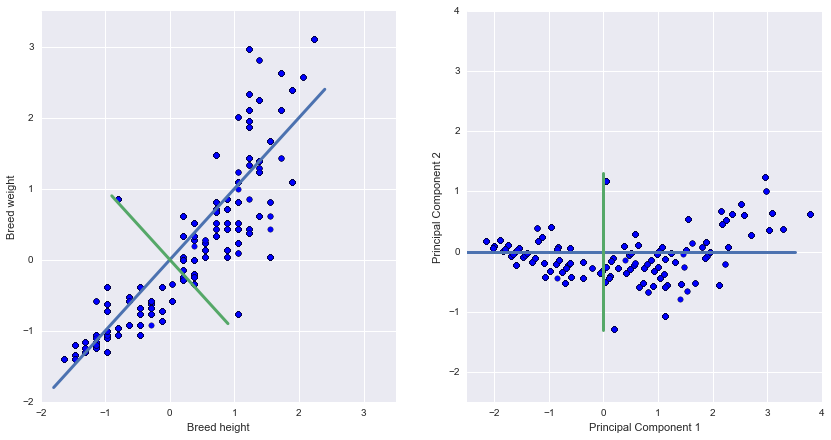

In [10]:
# Standardize the two features. It's usually 
# a good idea to do this prior to running PCA
df = data[['height', 'min_weight']].dropna()
df = (df - df.mean()) / df.std()

# compute the PCA using scikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df)

# set up the plotting space
fig, axes = plt.subplots(1, 2, figsize=(14,7))

# data points in original, unrotated features space
axes[0].scatter(df['height'], df['min_weight'], s=30)
axes[0].set_xlabel("Breed height")
axes[0].set_ylabel("Breed weight")
axes[0].set_ylim([-2, 3.5])
axes[0].set_xlim([-2, 3.5])
a, b = (0, pca.components_[0,1]/pca.components_[0,0])
axes[0].plot([-1.8, 2.4], [a + b*-1.8, a + b*2.4], lw=3)
a, b = (0, pca.components_[1,1]/pca.components_[1,0])
axes[0].plot([-.9, .9], [a + b*-.9, a + b*.9], lw=3)

# data points in rotated principal component (PC) space
rotated = pca.transform(df)
axes[1].scatter(-rotated[:,0], rotated[:,1], s=30)
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].set_ylim([-2.5, 4])
axes[1].set_xlim([-2.5, 4])
axes[1].plot([-2.7, 3.5], [0, 0], lw=3)
axes[1].plot([0, 0], [-1.3, 1.3], lw=3);

# How much of the total variance is explained by each PC?
msg = "The first principal component alone explains {:.0%} of the total variance."
print(msg.format(pca.explained_variance_ratio_[0]))

* It's clear that the first principal component contains most of the useful information that was shared between Height and Weight
* So if we simply drop the second principal component, we've effectively reduced our two features down to one feature with minimal information loss

### Now let's do PCA on our array of over 3000 features
* PCA on such a large array would be very computationally demanding and take a long time
* So we'll do a faster, approximate version of PCA called *Randomized PCA*

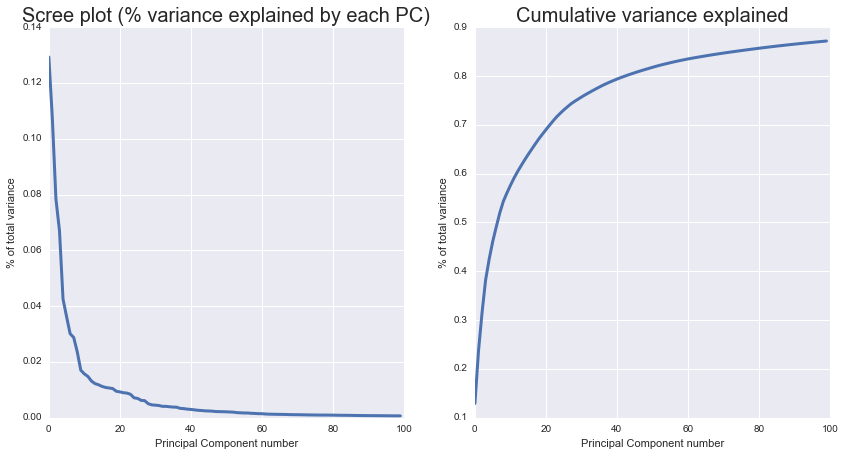

In [11]:
# First we need to recode our string column as a set of dummies
interaction_dummies = pd.get_dummies(data['ssb'])

# Let's concatenate this with the color features
# axis=1 indicates that we want to concatenate along
# the column axis (axis=0 would append each dataframe
# below the last.
lotsa_features = pd.concat([fur_features, interaction_dummies], axis=1)

# Like most other things in sklearn, decomposition classes
# implement the estimator interface. So they have fit() and
# predict() methods. Transformers also have a transform()
# method. First, we initialize the RandomizedPCA transformer.
# RandomizedPCA is a speedier approximation of the standard
# principal component analysis (PCA) factorization. We need to
# specify the number of components we want at initialization.
# We'll take the first 100.
from sklearn.decomposition import RandomizedPCA
rpca = RandomizedPCA(100)

# Now we can fit and transform in one step
rpca_features = rpca.fit_transform(lotsa_features)

# How much of the variance do these components explain?

# set up the plotting space
fig, axes = plt.subplots(1, 2, figsize=(14,7))

# scree plot
axes[0].plot(rpca.explained_variance_ratio_, lw=3)
axes[0].set_title('Scree plot (% variance explained by each PC)', size=20)
axes[0].set_xlabel('Principal Component number')
axes[0].set_ylabel('% of total variance')

# cumulative variance explained
axes[1].plot(np.cumsum(rpca.explained_variance_ratio_), lw=3)
axes[1].set_title('Cumulative variance explained', size=20)
axes[1].set_xlabel('Principal Component number')
axes[1].set_ylabel('% of total variance');

# Estimation
* With features in hand, we can now fit some models!
* scikit-learn has a bewildering array of models
* We'll talk about model selection shortly
* First we'll look at one model/algorithm in detail: **K-nearest neighbors (KNN)**
    * Easy to understand
    * Often competitive with more complicated models
    * Example of an algorithm really only used in machine learning context (no *data model*)

## K-nearest neighbors (KNN) algorithm
<img src="http://en.proft.com.ua/media/science/r_knn_concept.png" style="margin-bottom: 10px;" width="1000px">

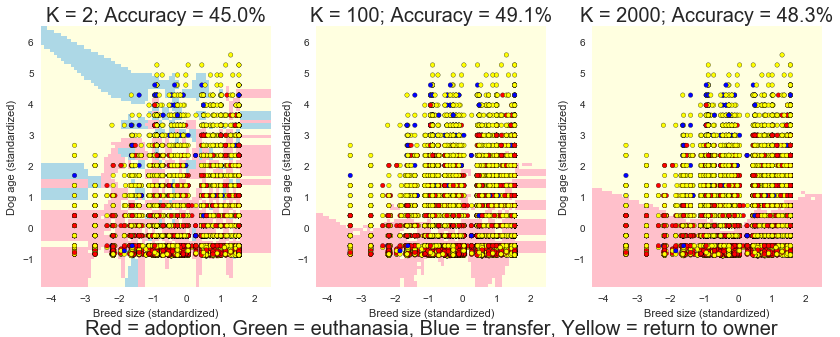

In [16]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap

# some data pre-processing
df = data[['height','min_weight']]
df = (df - df.mean()) / df.std()                # standardize before applying PCA.
df['size'] = np.dot(df, pca.components_.T)[:,0] # add PC1 as 'size'.
df['outcome'] = data['outcome']                 # append outcome in string form
df['y'] = LabelEncoder().fit_transform(data['outcome']) # and integer form.
df['age'] = data['age']                         # add the age predictor.
df = df.dropna()                                # drop missing values.
df = df.loc[df['outcome'] != 'Died',]           # drop 'Died' outcome (too few cases, 0.4%)
for v in ['age','size']:                        # standardize the predictors. KNN falters
    df[v] = (df[v] - df[v].mean())/df[v].std()  # if predictors on wildly different scales.

# define function to compute KNN for a given K and plot the result
def knn_plot(k, ax):
    knn = neighbors.KNeighborsClassifier(k)     # load the KNN classifier
    knn.fit(df[['size','age']], df['y'])        # fit the KNN model
    predicted = knn.predict(df[['size','age']]) # retrieve the outcomes predicted by KNN
    acc = accuracy_score(df['y'], predicted)    # compute accuracy of those predictions
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    h = .1  # step size in the mesh
    x_min, x_max = df['size'].min() - 1, df['size'].max() + 1
    y_min, y_max = df['age'].min() - 1, df['age'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Create color maps
    cmap_bold = ListedColormap(['red', 'green', 'blue', 'yellow'])
    cmap_light = ListedColormap(['pink', 'lightgreen', 'lightblue', 'lightyellow'])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    ax.scatter(df['size'], df['age'], c=df['y'], cmap=cmap_bold)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Breed size (standardized)')
    ax.set_ylabel('Dog age (standardized)')
    ax.set_title('K = {}; Accuracy = {:.1%}'.format(k, acc), size=20)
    
# set up the plotting space
fig, axes = plt.subplots(1, 3, figsize=(14,14/3))

# fit the models and make the plots
for k, ax in zip([2, 100, 2000], axes):
    knn_plot(k, ax)
axes[1].annotate(
    'Red = adoption, Green = euthanasia, Blue = transfer, Yellow = return to owner',
    xy=(0.5, 0), xytext=(0, -1),
    xycoords=('axes fraction', 'figure fraction'),
    textcoords='offset points',
    size=20, ha='center', va='bottom');

#### Is this good?
* Seems good, no?
* There are 4 classes, so chance should be 25%, right?
* Or should it...

In [17]:
# Show the relative class frequencies
counts = df['outcome'].value_counts()
counts/counts.sum()

Adoption           0.435473
Return to Owner    0.274337
Transfer           0.244381
Euthanasia         0.045809
Name: outcome, dtype: float64

## We can (probably) do better
* Let's use some of that giant mess of features we extracted!
* Also, the analysis above only used the dogs (which are about half the dataset), so let's use the full dataset
* Finally, it's really easy to plug in other classifiers, so let's try some of those

In [18]:
# For models with categoricals, we can call on
# patsy to dummy-code our variables, like we did
# when working with statsmodels
from patsy import dmatrix

# Some other estimators we can try (there are many more!)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC                      # support vector classifier
from sklearn.naive_bayes import BernoulliNB      # Naive Bayes for dummy predictors
from sklearn.linear_model import RidgeClassifier # ridge regression + classification rule

# plug in estimator of choice (just using default arguments)
est = neighbors.KNeighborsClassifier() # default K = 5
# est = RandomForestClassifier()
# est = DecisionTreeClassifier()
# est = SVC()
# est = BernoulliNB()
# est = RidgeClassifier()

# grab the outcome and encode it as integer rather than string
encoder = LabelEncoder()
y = encoder.fit_transform(data['outcome'])

# Set up the features, starting with 'age'
X = data['age']
X = np.c_[X.values, rpca_features[:,:20]]
# X = np.c_[X.values, lotsa_features]
for i in range(X.shape[1]): # standardize all predictors
    X[:,i] = (X[:,i] - X[:,i].mean())/X[:,i].std()

# fit the model/algorithm
est.fit(X, y)
y_predicted = est.predict(X)

# We're assessing accuracy *in the training set* so be skeptical!
accuracy_score(y, y_predicted)

0.67427840086221413

# Evaluation
* Evaluating model performance is rarely straightforward
* There are many criteria we might value
* Simple answers can be misleading
* Let's take a look at _how_ we classified different outcomes

### Confusion matrix
* How does the classifier go wrong?

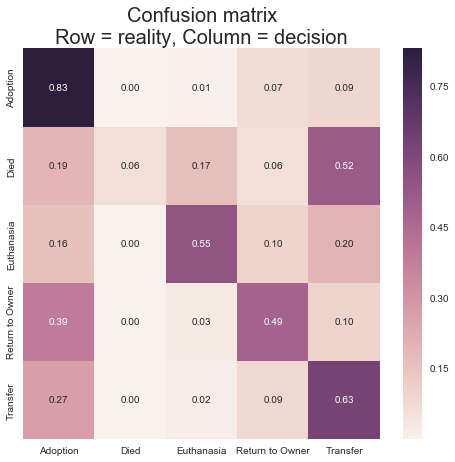

In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y, y_predicted):
    ''' take true and predicted scores and plot confusion matrix '''
    # Get the confusion matrix
    cm = confusion_matrix(y, y_predicted)

    # Normalize the confusion matrix by dividing each row by its sum
    ncm = cm / cm.sum(axis=1)[:, np.newaxis]

    # Put into DataFrame and get all labels from the encoder
    class_labels = encoder.classes_
    ncm = pd.DataFrame(ncm, index=class_labels, columns=class_labels)

    # Rows are true classes, columns are assigned classes
    sns.heatmap(data=ncm, fmt='.2f', annot=True)

plt.figure(figsize=(8,7))
plot_confusion_matrix(y, y_predicted)
plt.gca().set_title('Confusion matrix\nRow = reality, Column = decision', size=20);

In [20]:
# The classification report shows us performance for
# the most common metrics, by class
from sklearn.metrics import classification_report

print(classification_report(y, y_predicted))
print('Precision: Of all cases predicted to be X, how many really were X?')
print('Recall: Of all cases that really are X, how many were correctly predicted to be X?\n')

# which integer goes with which outcome?
# a cross-tab is a simple way to find out
print(pd.crosstab(data['outcome'], y))

             precision    recall  f1-score   support

          0       0.66      0.83      0.74     23840
          1       0.42      0.06      0.11       560
          2       0.79      0.55      0.65      5373
          3       0.55      0.49      0.52      9964
          4       0.73      0.63      0.68     19645

avg / total       0.68      0.67      0.67     59382

Precision: Of all cases predicted to be X, how many really were X?
Recall: Of all cases that really are X, how many were correctly predicted to be X?

col_0                0    1     2     3      4
outcome                                       
Adoption         23840    0     0     0      0
Died                 0  560     0     0      0
Euthanasia           0    0  5373     0      0
Return to Owner      0    0     0  9964      0
Transfer             0    0     0     0  19645


## Cross-validation
* Hopefully performance now looks reasonable
* But there's still a potential problem: overfitting
* We're training and evaluating on the same dataset--this is a big no-no!
* scikit-learn provides easy ways to evaluate models out-of-sample
    * This is known as cross-validation

In [21]:
# Import KFold cross-validation
from sklearn.cross_validation import KFold

# Placeholder for scores from each fold
scores = []

# Create k folds (in our case 5). Loop over the folds,
# and for each one, split the dataset into training and test.
# In each fold, we train the data on the training values,
# and then evaluate its performance on the test. Finally,
# we can take the average of the out-of-sample scores as
# our estimate of model performance.
folds = KFold(n=len(X), n_folds=5, shuffle=True)
print("Indices of training/test samples in each fold:")
for train, test in folds:
    print(train, test) # so we can see what's going on
    est.fit(X[train], y[train])
    pred_y = est.predict(X[test])
    fold_score = accuracy_score(y[test], pred_y)
    scores.append(fold_score)
    
# Overfitting be gone!
print("\nAccuracy in each fold:")
print(np.array(scores))

Indices of training/test samples in each fold:
[    0     3     4 ..., 59379 59380 59381] [    1     2     8 ..., 59362 59366 59374]
[    1     2     3 ..., 59377 59378 59380] [    0    13    15 ..., 59372 59379 59381]
[    0     1     2 ..., 59378 59379 59381] [    3     4     5 ..., 59371 59376 59380]
[    0     1     2 ..., 59379 59380 59381] [   12    16    17 ..., 59363 59365 59375]
[    0     1     2 ..., 59379 59380 59381] [    7    10    18 ..., 59373 59377 59378]

Accuracy in each fold:
[ 0.57741854  0.58145996  0.57906703  0.57233075  0.58352981]


# Model selection
* We've experimented a lot with estimators, decomposition, evaluation, etc.
* This is only the tip of the iceberg...
* scikit-learn has hundreds of estimators!
* Two problems:
    1. How are we supposed to choose?
    2. How do we do this in a principled way?
* Basically we can try different things and see what leads to the highest cross-validation error
* Caveat: *ALL* of the steps in our analysis pipeline...
    * ...all data pre-processing strategies we try...
    * ...all models we try...
    * ...all hyperparameters (e.g., K parameter in KNN) we try for each model...
* ...should ideally occur within another cross-validation loop, an idea called *nested cross-validation*

# Fully automated pipelines
* We've done feature extraction, reduction, and selection; estimation; evaluation...
* But we can automate this
    * Both for efficiency, and to prevent overfitting (greatly facilitates nested cross-validation)
* sklearn.pipeline provides functionality for creating [fully automated Pipelines](http://scikit-learn.org/stable/modules/pipeline.html)
* We'll build a toy example with 2 steps, but we could chain our entire workflow

In [30]:
# Import the Pipeline class
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

# Initialize a list to store all the steps in our pipeline
steps = []

# Add feature selection
selector = SelectKBest(k=100)
steps.append(('select', selector))

# Add estimation
estimator = LogisticRegression()
steps.append(('estimate', estimator))

# set up the predictors
_X = np.c_[data['age'].values, lotsa_features]
for i in range(_X.shape[1]): # standardize all predictors
    _X[:,i] = (_X[:,i] - _X[:,i].mean())/_X[:,i].std()

# Initialize and fit the pipeline
pipeline = Pipeline(steps)
_y_pred = pipeline.fit(_X, y)

## Building our own estimator:
### The fit-predict interface
* scikit-learn is built around the estimator interface
* "An estimator is an object that fits a model based on some training data and is capable of inferring some properties on new data"
* Every estimator must implement fit() and predict() methods
* Makes it easy to extend scikit-learn with our own estimators

In [34]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MercurialClassifier(BaseEstimator, ClassifierMixin):
    """Picks a random class and assigns that label to all cases."""

    def fit(self, X, y):
        ''' Selects a random class from the available options '''
        classes = np.unique(y)
        self.selected_ = np.random.choice(classes)
        return self

    def predict(self, X):
        ''' Applies the selected class to everything '''
        return np.repeat(self.selected_, len(X))

# The End
* I hope you enjoyed the course and/or learned something useful!
* The links throughout the notebooks contain plenty of further resources
* Consider registering for [SciPy 2017](https://scipy2017.scipy.org) (here in July)--they have great tutorials
* Feedback/suggestions for improvement is welcome
* Please fill out a course evaluation before you leave